# Introducción

El siguiente trabajo tiene el objetivo de analizar los salarios de jugadores profesionales de baloncesto en la NBA (National Basketball Association). Se busca, mediante el uso de una muestra de jugadores y un método estadístico (Test de Bondad de Ajuste chi-cuadrado), realizar una inferencia sobre la distribución que presentan los salarios, planteando la hipótesis de que siguen una distribución Exponencial. 
A sí mismo, se realiza una regresión lineal múltiple, con la finalidad de encontrar variables que expliquen el comportamiento del salario, y analizar su significancia en el valor de los mismo. 

Para tales objetivos, se obtuvieron datos de la situación contractual de cada jugador activo en la siguiente temporada 2023-2024, y sus rendimientos en la temporada anterior (2022-2023). Buscando si hay alguna relación en sus salarios actuales y sus desempeños previos.

In [ ]:
import pandas as pd
import os 
cwd = os.getcwd()
from statistics import pvariance, pstdev
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
import random
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

# Bondad de Ajuste

Para realizar la prueba de Bondad de Ajuste, se obtuvieron datos del salario de cada jugador de la NBA (En este trabajo todos los valores representan valores en moneda dólar estadounidense). Los mismos fueron extraídos del sitio https://www.basketball-reference.com. El mismo recopila información detallada de las estadísticas individuales de cada jugador año a año, así como la situación contractual. 

Se selecciona para el presente análisis, la información del año 2023-2024. Con un total de 443 jugadores.

In [57]:
df_salarios = pd.read_excel(cwd + '\\NBA_salarios_2023_2024.xlsx') # salarios de jugadores temporada 2023-2024

In [62]:
df_salarios

,Player,2023-24
0,Stephen Curry,51915615
1,Kevin Durant,47649433
2,Nikola Jokić,47607350
3,Joel Embiid,47607350
4,LeBron James,47607350
...,...,...
439,Juwan Morgan,576230
440,Malik Fitts,555217
441,Lamar Stevens,400000
442,Didi Louzada,268032


In [58]:
df_salarios[df_salarios.duplicated()== True] # check duplicates

,Player,2023-24
320,Dewayne Dedmon,7072674


In [59]:
df_salarios[df_salarios['Player'] == 'Dewayne Dedmon']

,Player,2023-24
264,Dewayne Dedmon,7072674
320,Dewayne Dedmon,7072674


In [64]:
df_salarios.drop_duplicates(subset=['Player'],keep='first',inplace=True) # drop duplicates from player
df_salarios

,Player,2023-24
0,Stephen Curry,51915615
1,Kevin Durant,47649433
2,Nikola Jokić,47607350
3,Joel Embiid,47607350
4,LeBron James,47607350
...,...,...
439,Juwan Morgan,576230
440,Malik Fitts,555217
441,Lamar Stevens,400000
442,Didi Louzada,268032


In [67]:
df_salarios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443 entries, 0 to 443
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Player   443 non-null    object
 1   2023-24  443 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.4+ KB


## Muestra Aleatoria

Para poder obtener la muestra, primero se establece el tamaño adecuado que debe tener la misma, de forma que los datos obtenidos sean representativos de la población.
Para calcular el tamaño de la muestra se usará la siguiente formula:

$$
n=\frac{N \cdot \sigma^2 \cdot Z_\alpha^2}{e^2 \cdot(N-1)+\sigma^2 \cdot Z_\alpha^2}
$$

Donde:

$\mathrm{n}=$ Tamaño adecuado de la muestra para nuestro análisis

$\mathrm{N}=$ Tamaño de la población

$\sigma^2=$ Varianza poblacional

$Z_\alpha$ : Valor obtenido mediante niveles de confianza, es un valor constante que surge de una distribución Normal Estándar, con media (cero) y varianza 1 (uno).

$e=$ Límite aceptable de error muestral




Para obtener la varianza poblacional se utiliza el módulo statistics integrado en Python que realiza el siguiente procedimiento:
$$
\frac{\sum_{i=0}^n\left(x_i-\mu\right)^2}{n}=\operatorname{Var}(\mathrm{x})=\sigma^2
$$
Siendo " $x_i$ " cada observación de $\mathrm{x} ; \mathrm{y}$ " $\mu$ " la media poblacional.

In [97]:
N = 443
var_poblacional = pvariance(df_salarios['2023-24'])
var_poblacional

129689415434830.36

Ahora que disponemos de la varianza poblacional, nos queda determinar $\left(Z_\alpha\right)$, se utiliza una confianza de $95 \%$ y utilizando una tabla de distribución normal estándar se obtiene un valor de 1,96. En cuanto al límite de error $(e)$ se empleara un criterio de $10 \%$ del desvío poblacional, esto es el $10 \%$ de $\sqrt{\operatorname{Var}(x)}$.
$$
e=0,1 \cdot \sqrt{129.689.415.434.830}= 1.138.812
$$



In [98]:
z = 1.96
e = 0.1 * pstdev(df_salarios['2023-24'])
e

1138812.6072134536

$$
\text { Por lo que ahora podemos obtener el tamaño de la muestra que vamos a utilizar: }
$$


$$
n=\frac{N \cdot \sigma^2 \cdot Z_\alpha^2}{e^2 \cdot(N-1)+\sigma^2 \cdot Z_\alpha^2}=\frac{443 \cdot 129.689.415.434.830 \cdot 1.96^2}{1.138.812^2 \cdot(443-1)+129.689.415.434.830 \cdot 1.96^2} \cong 206
$$


In [104]:
n = (N * var_poblacional * (z**2)) / ((e**2) * (443-1) + var_poblacional * (z**2))
n

205.9926406507214

Para obtener nuestras 206 observaciones, se realiza un método de muestreo aleatorio simple, que implica que cada elemento dentro de nuestra lista de salarios tiene la misma oportunidad de resultar seleccionado.
Este método nos asegura que cada una de las observaciones que resulte seleccionada será una variable aleatoria, cuya distribución de probabilidad es idéntica a la poblacional, a su vez, las mismas son independientes e idénticamente distribuidas, ya que ninguna
observación se ve afectada por otra.

In [110]:
muestra_salarios = df_salarios.sample(n=206)
muestra_salarios

,Player,2023-24
386,DeAndre Jordan,2019706
342,Wendell Moore Jr.,2421720
259,Taurean Prince,4516000
300,Eric Gordon,3196448
280,Malachi Flynn,3873025
...,...,...
141,Reggie Bullock,11014080
70,Clint Capela,20616000
123,Daniel Gafford,12402000
264,Dewayne Dedmon,7072674


In [139]:
muestra_salarios['2023-24'].describe().apply(lambda x: format(x,'f'))

count         206.000000
mean     11154945.820388
std      11675263.444061
min        400000.000000
25%       2589998.750000
50%       6364500.000000
75%      14303263.000000
max      47649433.000000
Name: 2023-24, dtype: object

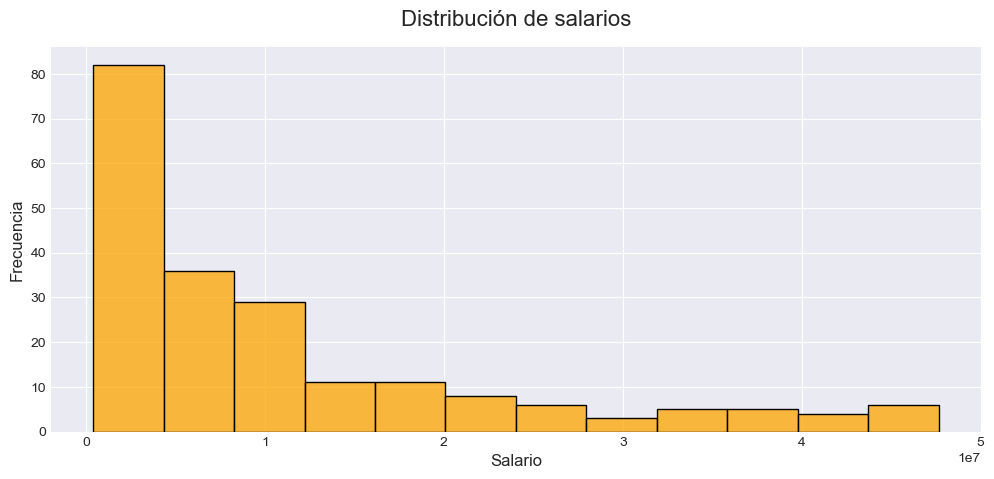

In [158]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.histplot(data=muestra_salarios, x='2023-24', ax=ax, color='orange')
ax.set_title(f'Distribución de salarios', {'fontsize': 16}, pad=15)
ax.set_xlabel('Salario', size=12)
ax.set_ylabel('Frecuencia', size=12)

plt.show()


Al tener tal concentración en valores menores, se puede observar en la distribución una marcada asimetría positiva, es decir, presenta una mayor densidad de observaciones hacia la izquierda de la media.

Por este motivo, se decide plantear como Hipótesis que los datos siguen una distribución exponencial, dicha distribución es adecuada para modelizar variables continuas con forma asimétrica positiva y, en especial, suele ser muy utilizada para modelizar ingresos salariales.

La distribución exponencial es un caso particular de la distribución gama, donde alpha es igual a 1 y beta es un valor positivo. Utilizaremos el término del parámetro escala $\beta=1 / \lambda$

De esta forma, la función de densidad queda definida como:
$$
f_X(x, \beta)=\frac{1}{\beta} e^{-\frac{x}{\beta}}
$$
Para todo $x \geq 0$
Donde:

La esperanza de $\mathrm{x}: \mathrm{E}(\mathrm{x})=\beta$

La varianza de $\mathrm{x}: \operatorname{Var}(\mathrm{x})=\beta^2$


# Test de bondad de ajuste chi-cuadrado

Definiremos nuestra variable a estudiar

X: Salario de jugadores NBA en 2023-2024

Se intentará inferir la distribución que siguen los salarios mediante una prueba que mide la discrepancia entre una distribución observada (en este caso, nuestra variable X) y otra teórica. Realizaremos una prueba, de igual contra mayor, para decidir si nuestros datos se apegan a una distribución exponencial.

Primero, plantemos nuestra hipótesis nula:

$$
H_0: F(x)=F_0(x)
$$

Donde $F_0(x)$ es nuestro modelo de probabilidad exponencial propuesto.

El estadístico de prueba es el siguiente:

$$
D^2=\sum_{i=0}^k \frac{\left(\text { observada }_i-\text { teorica }_i\right)^2}{\text { teorica }_i} \sim \chi_t^2(k-1-r)
$$

Y nuestro criterio de decisión es el siguiente:

$$
D^2<\chi_t^2(k-1-r)
$$

Donde los grados de libertad de la chi-cuadrado $(k-1-r)$ son:

$\mathrm{k}=$ cantidad de clases exhaustivas y mutuamente excluyentes

$r=$ número de parámetros estimados

$t$ representa el valor proporcionado por la distribución, según el nivel de significación elegido, en este caso elegiremos un $5 \%$ de significación (Error de Tipo 1).


In [143]:
# Datos observados
observed_data = muestra_salarios['2023-24']

# Calcular las frecuencias esperadas bajo una distribución exponencial
# (parámetro lambda se calcula como 1 / media)
mean = np.mean(observed_data)
expected_data = np.exp(-observed_data / mean) * np.sum(observed_data)

# Realizar el cálculo del estadístico Chi-cuadrado
chi_squared_stat = np.sum((observed_data - expected_data)**2 / expected_data)

# Grados de libertad (número de categorías menos 1)
degrees_of_freedom = len(observed_data) - 1

# Valor crítico del Chi-cuadrado para un nivel de significancia y grados de libertad
significance_level = 0.05
critical_value = chi2.ppf(1 - significance_level, degrees_of_freedom)

# Realizar el test de Chi-cuadrado
p_value = 1 - chi2.cdf(chi_squared_stat, degrees_of_freedom)

print("Chi-cuadrado estadístico:", chi_squared_stat)
print("Grados de libertad:", degrees_of_freedom)
print("Valor crítico Chi-cuadrado:", critical_value)
print("Valor p:", p_value)

if chi_squared_stat >= critical_value:
    print("Rechazar la hipótesis nula: Los datos no siguen la distribución exponencial.")
else:
    print("No se puede rechazar la hipótesis nula: Los datos siguen la distribución exponencial.")


Chi-cuadrado estadístico: 239166384499.38733
Grados de libertad: 205
Valor crítico Chi-cuadrado: 239.40343947825167
Valor p: 0.0
Rechazar la hipótesis nula: Los datos no siguen la distribución exponencial.


El estadístico de prueba nos da un valor mayor a nuestro valor crítico, lo que nos indica rechazar nuestra $H_0$ sobre la forma funcional de la población. También podemos verlo mediante el P-value, que contiene la probabilidad asociada al estadístico de prueba, el mismo es menor a nuestra región critica de 0,05.


# Regresión Lineal Múltiple

Para realizar un estudio sobre cuales aspectos del desempeño de los jugadores tiene relación con sus salarios, se obtiene una muestra, de igual proceso como con la Bondad de Ajuste. Como estamos analizando los salarios en 2023-2024 y el desempeño de los jugadores en la temporada anterior (2022-2023), la población se reduce, ya que hay jugadores que no continúan en la liga. Por lo que ahora nuestra población consiste en 392 jugadores.

In [159]:
df_stats = pd.read_excel(cwd + '\\NBA_stats_2022_2023.xlsx') # estadisticas de jugadores temporada 2022-2023

In [160]:
#stats se repiten nombres jugadores porque desagrega por equipo (cuando jugador juega para mas de un equipo en la temporada)
df_stats[:10]

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,23,55,12,20.7,3.6,7.3,0.485,0.5,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,Steven Adams,C,29,42,42,27.0,3.7,6.3,0.597,0.0,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,Bam Adebayo,C,25,75,75,34.6,8.0,14.9,0.540,0.0,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,Ochai Agbaji,SG,22,59,22,20.5,2.8,6.5,0.427,1.4,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,Santi Aldama,PF,22,77,20,21.8,3.2,6.8,0.470,1.2,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0
5,Nickeil Alexander-Walker,SG,24,59,3,15.0,2.2,5.0,0.444,1.0,...,0.667,0.3,1.5,1.7,1.8,0.5,0.4,0.9,1.5,6.2
6,Nickeil Alexander-Walker,SG,24,36,3,14.7,2.3,4.7,0.488,1.0,...,0.692,0.2,1.4,1.6,2.1,0.7,0.4,1.3,1.6,6.3
7,Nickeil Alexander-Walker,SG,24,23,0,15.5,2.1,5.4,0.384,1.1,...,0.619,0.3,1.5,1.8,1.4,0.3,0.3,0.4,1.3,5.9
8,Grayson Allen,SG,27,72,70,27.4,3.4,7.7,0.440,2.0,...,0.905,0.8,2.4,3.3,2.3,0.9,0.2,1.0,1.6,10.4
9,Jarrett Allen,C,24,68,68,32.6,5.9,9.2,0.644,0.0,...,0.733,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3


In [162]:
df_stats.drop_duplicates(subset = ['Player'],keep='first',inplace=True) # drop duplicates from player
df_stats[:10]

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,23,55,12,20.7,3.6,7.3,0.485,0.5,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,Steven Adams,C,29,42,42,27.0,3.7,6.3,0.597,0.0,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,Bam Adebayo,C,25,75,75,34.6,8.0,14.9,0.540,0.0,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,Ochai Agbaji,SG,22,59,22,20.5,2.8,6.5,0.427,1.4,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,Santi Aldama,PF,22,77,20,21.8,3.2,6.8,0.470,1.2,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0
5,Nickeil Alexander-Walker,SG,24,59,3,15.0,2.2,5.0,0.444,1.0,...,0.667,0.3,1.5,1.7,1.8,0.5,0.4,0.9,1.5,6.2
8,Grayson Allen,SG,27,72,70,27.4,3.4,7.7,0.440,2.0,...,0.905,0.8,2.4,3.3,2.3,0.9,0.2,1.0,1.6,10.4
9,Jarrett Allen,C,24,68,68,32.6,5.9,9.2,0.644,0.0,...,0.733,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3
10,Jose Alvarado,PG,24,61,10,21.5,3.3,8.0,0.411,1.4,...,0.813,0.5,1.9,2.3,3.0,1.1,0.2,1.3,2.0,9.0
11,Kyle Anderson,PF,29,69,46,28.4,3.7,7.2,0.509,0.6,...,0.735,1.0,4.4,5.3,4.9,1.1,0.9,1.5,2.1,9.4


In [164]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 678
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  539 non-null    object 
 1   Pos     539 non-null    object 
 2   Age     539 non-null    int64  
 3   G       539 non-null    int64  
 4   GS      539 non-null    int64  
 5   MP      539 non-null    float64
 6   FG      539 non-null    float64
 7   FGA     539 non-null    float64
 8   FG%     537 non-null    float64
 9   3P      539 non-null    float64
 10  3PA     539 non-null    float64
 11  3P%     523 non-null    float64
 12  2P      539 non-null    float64
 13  2PA     539 non-null    float64
 14  2P%     534 non-null    float64
 15  eFG%    537 non-null    float64
 16  FT      539 non-null    float64
 17  FTA     539 non-null    float64
 18  FT%     515 non-null    float64
 19  ORB     539 non-null    float64
 20  DRB     539 non-null    float64
 21  TRB     539 non-null    float64
 22  AS

In [167]:
df_regresion = df_salarios.merge(df_stats, left_on='Player', right_on='Player')
df_regresion

,Player,2023-24,Pos,Age,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Stephen Curry,51915615,PG,34,56,56,34.7,10.0,20.2,0.493,...,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4
1,Kevin Durant,47649433,PF,34,47,47,35.6,10.3,18.3,0.560,...,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1
2,Nikola Jokić,47607350,C,27,69,69,33.7,9.4,14.8,0.632,...,0.822,2.4,9.4,11.8,9.8,1.3,0.7,3.6,2.5,24.5
3,Joel Embiid,47607350,C,28,66,66,34.6,11.0,20.1,0.548,...,0.857,1.7,8.4,10.2,4.2,1.0,1.7,3.4,3.1,33.1
4,LeBron James,47607350,PF,38,55,54,35.5,11.1,22.2,0.500,...,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,Kenneth Lofton Jr.,1719864,PF,20,24,1,7.3,2.0,3.9,0.527,...,0.593,0.8,1.3,2.1,0.8,0.2,0.1,0.5,1.2,5.0
388,Max Christie,1719864,SG,19,41,3,12.5,1.1,2.6,0.415,...,0.875,0.2,1.7,1.8,0.5,0.2,0.2,0.3,0.8,3.1
389,Bryce McGowens,1719864,SG,20,46,7,17.1,1.7,4.4,0.396,...,0.750,0.4,1.6,2.0,1.2,0.3,0.1,0.9,1.0,5.3
390,Jabari Walker,1719864,SF,20,56,0,11.1,1.5,3.5,0.419,...,0.756,0.9,1.5,2.3,0.6,0.2,0.2,0.5,1.2,3.9


Para obtener el tamaño de nuestra muestra, reutilizamos la fórmula: 



$$
n=\frac{N \cdot \sigma^2 \cdot Z_\alpha^2}{e^2 \cdot(N-1)+\sigma^2 \cdot Z_\alpha^2}
$$

Donde:

$\mathrm{N}=$ 392

$\sigma^2=$ 138.905.837.217.288

$Z_\alpha$ = 1.96

$e=$ 1.178.583

In [175]:
N = 392
var_poblacional = pvariance(df_regresion['2023-24'])
z = 1.96
e = 0.1 * pstdev(df_regresion['2023-24'])
n = (N * var_poblacional * (z**2)) / ((e**2) * (392-1) + var_poblacional * (z**2))

print(f'Variacion poblacional= {var_poblacional}')
print(f'e = {e}')
print(f'Muestra (n)= {n}')

Variacion poblacional= 138905837217288.22
e = 1178583.2054517332
Muestra (n)= 194.2704989937561


Entonces: 

$$
n=\frac{N \cdot \sigma^2 \cdot Z_\alpha^2}{e^2 \cdot(N-1)+\sigma^2 \cdot Z_\alpha^2}=\frac{392 \cdot 138.905.837.217.288 \cdot 1.96^2}{1.178.583^2 \cdot(392-1)+138.905.837.217.288 \cdot 1.96^2} \cong 195
$$


Mediante un muestreo aleatorio simple, se obtienen 195 jugadores y su correspondiente salario y performance en la temporada, la misma se basa en estadísticas por juego, son métricas de popular uso para medir el desempeño de un jugador en esta liga, dentro de las cuales se encuentran “puntos por juego”, “asistencias por juego”, “minutos jugados por juego”, entre otras.

In [210]:
#muestra_regresion = df_regresion.sample(n=195)
#muestra_regresion.to_csv('muestra_regresion.csv',index=False)

In [212]:
datos_regresion = pd.read_csv(cwd + "\muestra_regresion.csv")
datos_regresion

,Player,2023-24,Pos,Age,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Aaron Holiday,2019706,PG,26,63,6,13.4,1.5,3.5,0.418,...,0.844,0.4,0.8,1.2,1.4,0.6,0.2,0.6,1.3,3.9
1,Killian Hayes,7413955,PG,21,76,56,28.3,4.0,10.7,0.377,...,0.821,0.4,2.5,2.9,6.2,1.4,0.4,2.3,2.9,10.3
2,Kevin Porter Jr.,15860000,PG,22,59,59,34.3,6.6,15.0,0.442,...,0.784,1.3,4.0,5.3,5.7,1.4,0.3,3.2,2.6,19.2
3,Deandre Ayton,32459438,C,24,67,67,30.4,7.8,13.2,0.589,...,0.760,2.6,7.4,10.0,1.7,0.6,0.8,1.8,2.8,18.0
4,Blake Wesley,2504640,SG,19,37,1,18.1,1.9,5.8,0.321,...,0.591,0.3,1.9,2.2,2.7,0.7,0.1,1.8,1.8,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Montrezl Harrell,2019706,C,29,57,7,11.9,2.2,3.7,0.598,...,0.693,1.2,1.6,2.8,0.6,0.3,0.4,0.6,1.3,5.6
191,Isaac Okoro,8920795,SF,22,76,46,21.7,2.3,4.7,0.494,...,0.757,0.7,1.8,2.5,1.1,0.7,0.4,0.6,2.1,6.4
192,Garrett Temple,5401000,SG,36,25,0,6.5,0.7,1.8,0.400,...,0.750,0.2,0.5,0.7,0.5,0.4,0.1,0.2,0.6,2.0
193,Tobias Harris,39270150,SF,30,74,74,32.9,5.7,11.4,0.501,...,0.876,0.9,4.8,5.7,2.5,0.9,0.5,1.2,2.0,14.7


Encoding de variable categorica

In [213]:
datos_regresion['Pos'].unique()

array(['PG', 'C', 'SG', 'PF', 'SF', 'SG-PG', 'SF-PF'], dtype=object)

In [214]:
datos_regresion['Pos'].replace({'SF-PF':'SF','SG-PG':'SG'},inplace=True)

In [216]:
datos_regresion['Pos'].unique()

array(['PG', 'C', 'SG', 'PF', 'SF'], dtype=object)

In [217]:
map_dict = {
    'PG':0,
    'SG': 1,
    'SF': 2,
    'PF': 3,
    'C': 4 
}

datos_regresion['Pos'] = datos_regresion['Pos'].map(map_dict)
datos_regresion

,Player,2023-24,Pos,Age,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Aaron Holiday,2019706,0,26,63,6,13.4,1.5,3.5,0.418,...,0.844,0.4,0.8,1.2,1.4,0.6,0.2,0.6,1.3,3.9
1,Killian Hayes,7413955,0,21,76,56,28.3,4.0,10.7,0.377,...,0.821,0.4,2.5,2.9,6.2,1.4,0.4,2.3,2.9,10.3
2,Kevin Porter Jr.,15860000,0,22,59,59,34.3,6.6,15.0,0.442,...,0.784,1.3,4.0,5.3,5.7,1.4,0.3,3.2,2.6,19.2
3,Deandre Ayton,32459438,4,24,67,67,30.4,7.8,13.2,0.589,...,0.760,2.6,7.4,10.0,1.7,0.6,0.8,1.8,2.8,18.0
4,Blake Wesley,2504640,1,19,37,1,18.1,1.9,5.8,0.321,...,0.591,0.3,1.9,2.2,2.7,0.7,0.1,1.8,1.8,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Montrezl Harrell,2019706,4,29,57,7,11.9,2.2,3.7,0.598,...,0.693,1.2,1.6,2.8,0.6,0.3,0.4,0.6,1.3,5.6
191,Isaac Okoro,8920795,2,22,76,46,21.7,2.3,4.7,0.494,...,0.757,0.7,1.8,2.5,1.1,0.7,0.4,0.6,2.1,6.4
192,Garrett Temple,5401000,1,36,25,0,6.5,0.7,1.8,0.400,...,0.750,0.2,0.5,0.7,0.5,0.4,0.1,0.2,0.6,2.0
193,Tobias Harris,39270150,2,30,74,74,32.9,5.7,11.4,0.501,...,0.876,0.9,4.8,5.7,2.5,0.9,0.5,1.2,2.0,14.7


## Regresion lineal multiple

Para este análisis se seleccionan las siguientes 4 variables, que presentan significatividad en el modelo de regresión. P-value <0.05

Age = Edad del jugador

G = Partidos jugados en la temporada

TOV = Perdidas de balon por partido

PTS = Puntos por partido 

Planteamos nuestra ecuación de regresión, que involucra una variable respuesta ($y_i$) como función de varias variables explicativas ($x_i$).

Ecuación de regresión múltiple:

$$y_i=\beta_0+\beta_1x_{i1}+\beta_{2^\ }x_{i2}+\beta_{3^\ }x_{i3}+\beta_{4^\ }x_{i4}+\varepsilon_i\ \ $$

Donde: 

$y_{i\ }$= Salario 

$x_{i1\ }$ = Edad del jugador

$x_{i2}$ = Partidos jugados en la temporada 

$x_{i3}$ = Perdidas de balon por partido 

$x_{i4}$ = Puntos por partido

$\varepsilon_i$ = Error aleatorio no observable asociado con $y_{i\ }$

$\beta_0$ = Valor de la respuesta media cuando todas las variables de predicción valen cero 

$\beta_j\ siendo\ j\ =1,\ 2,\ 3,\ 4$ 

Este modelo supone el caso de la teoría basada en el modelo normal, donde las observaciones $y_{i\ }$ son variables aleatorias independientes, normalmente distribuidas con: 

$$E(y_{i\ })=\beta_0+\beta_1x_{i1}+\beta_{2^\ }x_{i2}+\beta_{3^\ }x_{i3}+\beta_{4^\ }x_{i4}$$

$$Var(y_{i\ })=\sigma^2$$ 

$$i=1,\ 2,\ 3,\ ...,\ n$$


Para estimar nuestros parámetros $\beta$ usamos el método de mínimos cuadrados, que consistete en minimizar la suma de los errores cuadraticos.

La función de error cuadrático está dada por: 

$$S\left(\beta_0,\beta_1,\beta_2,\beta_3\right)\ =\ \sum_{i=1}^{n}\left(y_i-\beta_0-\beta_1x_{i1}-\ \beta_2x_{i2}-\beta_3x_{i3}-\beta_4x_{i4}\right)^2=\ \sum_{i=1}^{n}\varepsilon_i^2$$

Para minimizar la función, se realiza una derivación de la misma respecto a cada parámetro y se iguala a cero. 

$$\frac{\partial\sum_{i=1}^{n}\varepsilon_i^2}{\partial\beta_j}=0$$


Resolver este sistema de forma analítica es complicado, por lo que, el resultado de este sistema de ecuaciones se expresa en forma matricial como

$$\left(X^t\cdot X\right)B=X^t\cdot Y$$

donde:

$$  Y = \left(\begin{matrix}y_1\\y_2\\\vdots\\y_n\\\end{matrix}\right)\ \ \    B= \left(\begin{matrix}\beta_0\\\beta_1\\\beta_2\\\beta_3\\\beta_4\\\end{matrix}\right)   X = \left(\begin{matrix}1&x_{11\ }&\ldots&x_{14}\\1&x_{21\ }&\ldots&x_{24}\\\vdots&\vdots&\ddots&\vdots\\1&x_{n1\ }&\ldots&x_{n4}\\\end{matrix}\right)    X^t= \left(\begin{matrix}1&1&\ldots&1\\x_{11\ }&x_{21\ }&\ldots&x_{n1\ }\\\vdots&\vdots&\ddots&\vdots\\x_{14}&x_{24}&\ldots&x_{n4}\\\end{matrix}\right)                 $$

Si la matriz inversa $\left(X^t\cdot X\right)^{-1}$ existe, se multiplica en ambos lados: 
$$\left(X^t\cdot X\right)^{-1}\cdot\left(X^t\cdot X\right)B={\left(X^t\cdot X\right)^{-1}\cdot(X}^t\cdot Y)$$

Entonces el estimador por mínimos cuadrados está dado por: 

$$B={\left(X^t\cdot X\right)^{-1}\cdot(X}^t\cdot Y)$$





In [ ]:
X = datos_regresion.drop(['Player','2023-24'], axis=1)
y = datos_regresion['2023-24']

In [307]:
columns = ['Age', 'G','TOV', 'PTS']

X = X[columns]
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                2023-24   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     117.9
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           2.26e-50
Time:                        02:45:37   Log-Likelihood:                -3326.0
No. Observations:                 195   AIC:                             6662.
Df Residuals:                     190   BIC:                             6678.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.606e+07   3.15e+06     -5.103      0.0

Realizando la regresión, obtenemos los coeficientes  de nuestros parámetros $\beta$:

Intercepto ($\beta_0$) = -16.063.520

Edad del jugador ($\beta_1$) = 624.616

Partidos jugados en la temporada ($\beta_2$) = -68.044

Perdidas de balon por partido ($\beta_3$) = -2.466.739

Puntos por partido ($\beta_4$) = 1.713.683


Al ser un modelo lineal, podemos interpretar a los coeficientes (β1, β2, β3,β4) como la cantidad en la que cambia nuestra variable respuesta (Salario) cuando una variable explicativa cambia en una unidad, permaneciendo el resto de las variables constante.

En nuestro caso, vemos que el ingreso crece $624.616 con un año más de edad, el resto constante; que un aumento de un punto por partido aumenta en $1.713.683 el salario; que un aumento de un partido jugado en la temporada disminuye el ingreso en -68.044; y un aumento en perdidas de balon por partido disminuye el ingreso en -2.466.739. En cuanto al intercepto (β0), representa la respuesta media de la variable respuesta, cuando las explicativas son todas nulas, no tiene ningún significado en particular como un término separado del modelo de regresión.




# Supuestos del modelo


En esta sección se realiza un análisis para buscar violaciones de los supuestos en nuestra regresión o deficiencias del modelo.

## Multicolinealidad

Cuando existe una correlación muy fuerte entre variables predictivas, los resultados de la predicción serán ambiguos, especialmente con respecto a los valores de los coeficientes de regresión estimados. Esto constituye lo que se conoce como Multicolinealidad.

Se utiliza la matriz de correlación entre variables predictoras:

<AxesSubplot:>

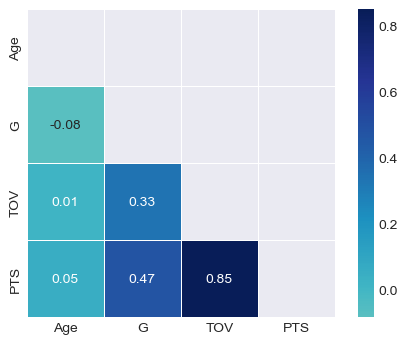

In [301]:
corr = X[columns].corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5, fmt='.2f')

Podemos ver que existe una fuerte correlación entre Perdidas de balon y Puntos por partido de 0.85. Por lo que se realiza una prueba para determinar si existe colinealidad.

Utilizamos el método Factor de inflación de la varianza (FIV), que realiza una regresión que tiene a una variable explicativa como una función de las demás variables explicativas. Por ejemplo, para el caso de Edad, sería:

$$x_{i1}=\beta_0+\beta_{2^\ }x_{i2}+\beta_{3^\ }x_{i3}+\beta_{4^\ }x_{i4}+\varepsilon_i$$

y utiliza el $R_i^2$ de esta regresión auxiliar para formar el (FIV):

$${FIV}_i=\frac{1}{1-R_i^2}$$

Cuanto mayor sea $R_i^2$, significa que hay un problema de colinealidad, ya que una variable predictora se explica por las demás variables predictoras. A su vez, cuanto mayor es $R_i^2$ mayor es (FIV). 



In [298]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const    49.224411
Age       1.019407
G         1.222316
TOV       3.694462
PTS       4.084665
dtype: float64

Observamos que el FIV  de cada variable se encuentra en valores pequeños y moderados cercanos a 1, que es el menor valor que puede tener. De esta forma, se descarta la presencia de un problema de colinealidad.

## Análisis de residuos

Se puede utilizar gráficos de los residuos contra los correspondientes valores de cada una de las variables de predicción, para verificar si el modelo es lineal o no. A su vez, se puede determinar problemas sobre la varianza del error, graficando los residuos contra los correspondientes valores estimados de la respuesta.  

Uno de los supuestos de Gauss-Márkov es la varianza constante de los errores. 
$$Var\left(e_i\right)=\sigma^2$$

La existencia de heterocedasticidad, es decir, la tendencia a aumentar o disminuir los residuos al aumentar los valores estimados de la respuesta, no hace que los estimadores pierdan su propiedad de insesgados, pero ya no son eficientes. 

Viendo el grafico de los residuos contra la variable predictora Edad, se puede apreciar una nube de puntos sin clara forma. No parece presentar problemas. 


In [308]:
residuals = model.resid
fitted_values = model.predict() 

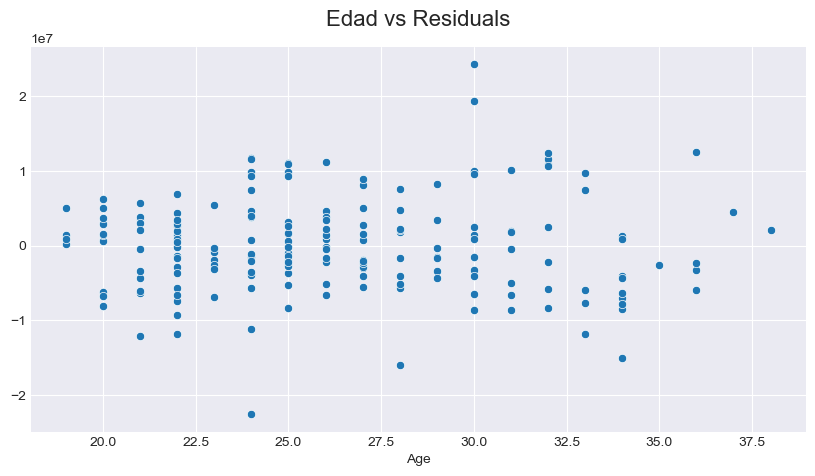

In [325]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=X['Age'],y=residuals)
ax.set_title('Edad vs Residuals',{'fontsize': 16},pad=15)

plt.show()

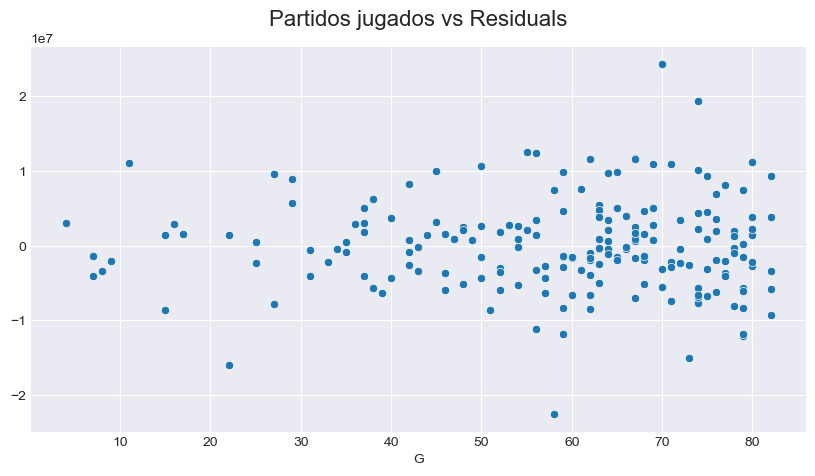

In [326]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=X['G'],y=residuals)
ax.set_title('Partidos jugados vs Residuals',{'fontsize': 16},pad=15)

plt.show()

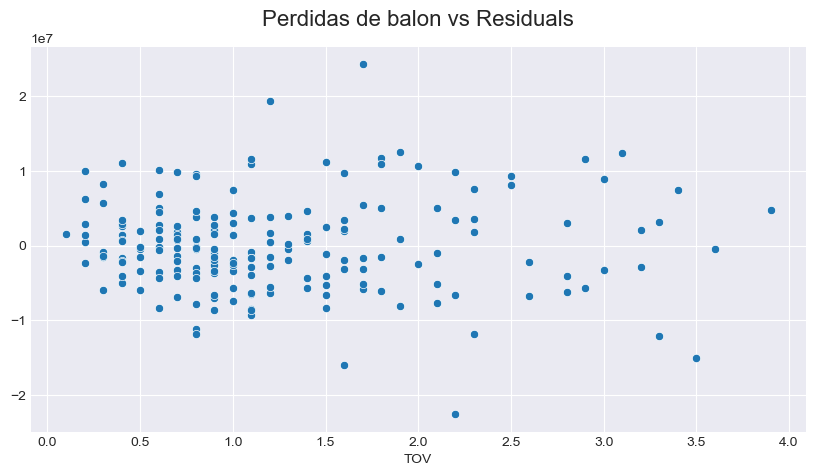

In [327]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=X['TOV'],y=residuals)
ax.set_title('Perdidas de balon vs Residuals',{'fontsize': 16},pad=15)

plt.show()

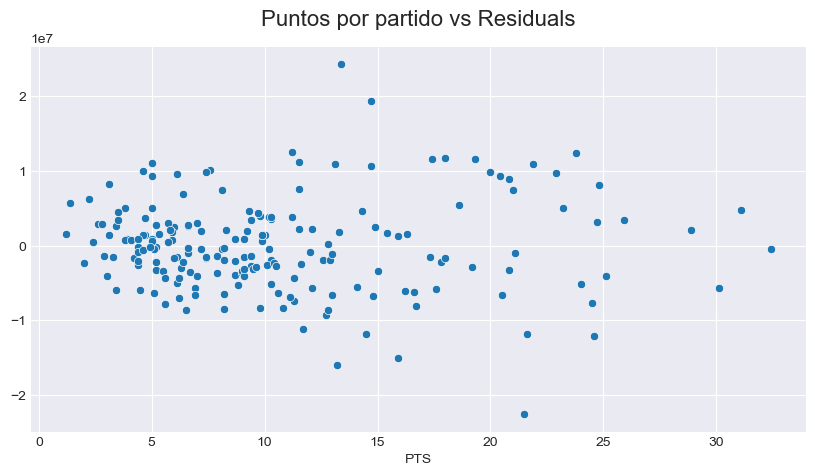

In [328]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=X['PTS'],y=residuals)
ax.set_title('Puntos por partido vs Residuals',{'fontsize': 16},pad=15)

plt.show()

En los ultimos graficos se puede llegar a apreciar cierta tendencia. Para comprobar una situación de heterocedasticidad, graficamos los valores esperados de la variable respuesta contra sus residuos. 

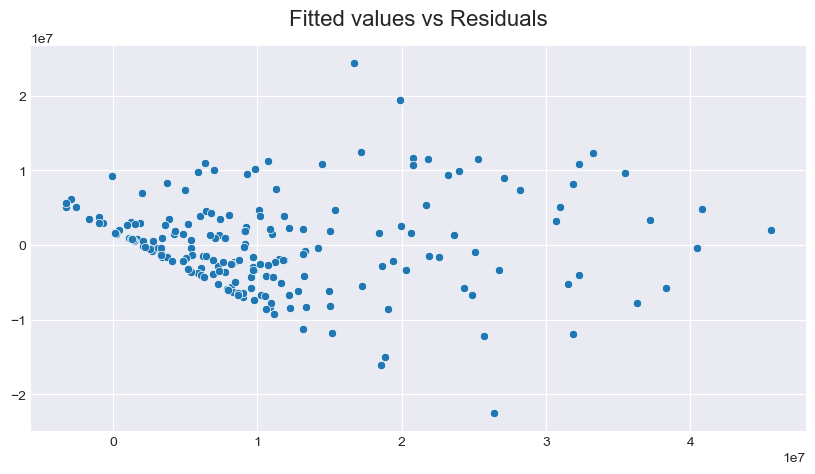

In [329]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=fitted_values,y=residuals)
ax.set_title('Fitted values vs Residuals',{'fontsize': 16},pad=15)

plt.show()

Los residuos presentan una tendencia, y no vemos una nube de puntos sin forma, como se desearía. 

Vamos a realizar una prueba de hipótesis para determinar si existe heterocedasticidad de forma analítica. Utilizaremos el Test de White. 
Donde las hipótesis son:

(Homocedasticidad) 
$$H_0:\ {\sigma^2}_{\varepsilon_i}={\sigma^2}_{\varepsilon_\ }$$

(Heterocedasticidad) 
$$H_1:\ {\sigma^2}_{\varepsilon_i}=C\cdot{{x_{ij}^2}^\ }_\$$  


Para realizar esta prueba, elevamos los residuos al cuadrado para poder realizar una regresión auxiliar con los ${\hat{\varepsilon}}_i^2$ como variable respuesta, y como variables predictoras tomamos las variables explicativas que utilizamos en la regresión inicial, sus cuadrados, y los términos cruzados.

El estadístico de prueba es el siguiente: 

$$n\cdot R^2\ =\ \chi_p^2$$

Donde: 

$R^2$ : coeficiente de determinación de la regresión auxiliar

$p$ : número de variables explicativas de la regresión auxiliar


In [336]:
white_test = het_white(residuals,model.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'Test Statistic': 32.2997787386043, 'Test Statistic p-value': 0.0036308767065014952, 'F-Statistic': 2.552441946769965, 'F-Test p-value': 0.0023129023206744266}


El P-value de la prueba es menor a 0,05 por lo que se rechaza la $H_0$. 

Ante la presencia de Heterocedasticidad, una posible solución es realizar una transformación logarítmica (modelo Log-Log). Por lo que nuestra nueva ecuación de regresión es:
 
$$lny_i=\beta_0+\beta_1lnx_{i1}+\beta_{2^\ }lnx_{i2}+\beta_{3^\ }lnx_{i3}+\beta_{4^\ }lnx_{i4}+\varepsilon_i\ \$$ 

Realizamos la estimación de los parámetros y comparamos los valores esperados de la variable respuesta con sus residuos. 


In [343]:
X_log = X[['Age','G','TOV','PTS']]
X_log = np.log(X_log)
X_log 

,Age,G,TOV,PTS
0,3.258097,4.143135,-0.510826,1.360977
1,3.044522,4.330733,0.832909,2.332144
2,3.091042,4.077537,1.163151,2.954910
3,3.178054,4.204693,0.587787,2.890372
4,2.944439,3.610918,0.587787,1.609438
...,...,...,...,...
190,3.367296,4.043051,-0.510826,1.722767
191,3.091042,4.330733,-0.510826,1.856298
192,3.583519,3.218876,-1.609438,0.693147
193,3.401197,4.304065,0.182322,2.687847


In [345]:
y_log = np.log(y)
y_log

0      14.518463
1      15.818875
2      16.579311
3      17.295502
4      14.733656
         ...    
190    14.518463
191    16.003896
192    15.502095
193    17.485975
194    14.518463
Name: 2023-24, Length: 195, dtype: float64

In [346]:
X_log  = sm.add_constant(X_log) # adding a constant
model_log = sm.OLS(y_log, X_log).fit()

print_model_log = model_log.summary()
print(print_model_log)

                            OLS Regression Results                            
Dep. Variable:                2023-24   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     69.95
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           2.58e-36
Time:                        03:38:34   Log-Likelihood:                -187.74
No. Observations:                 195   AIC:                             385.5
Df Residuals:                     190   BIC:                             401.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1415      1.002      8.123      0.0

In [347]:
residuals_log = model_log.resid
fitted_values_log = model_log.predict() 

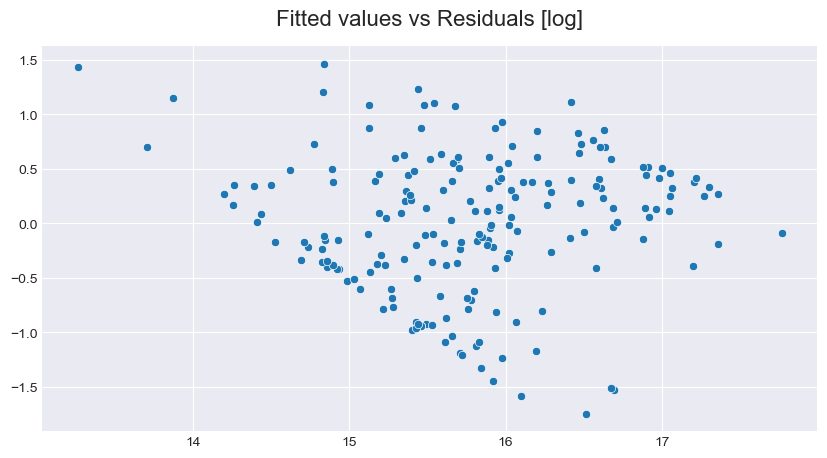

In [348]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.scatterplot(x=fitted_values_log,y=residuals_log)
ax.set_title('Fitted values vs Residuals [log]',{'fontsize': 16},pad=15)

plt.show()

Realizamos nuevamente la prueba de White y el resultado es el siguiente:

In [349]:
white_test_log = het_white(residuals_log,model_log.model.exog)
print(dict(zip(labels, white_test_log)))

{'Test Statistic': 19.685530221533465, 'Test Statistic p-value': 0.14037177133429066, 'F-Statistic': 1.443689585900607, 'F-Test p-value': 0.13711462793139337}


Al ser el P-value > 0,05 no rechazamos la $H_0$ de Homocedasticidad. Vemos que la transformación logarítmica reduce la heterocedasticidad, esto sucede porque comprime las escalas en las cuales se miden las variables. 
A su vez, ofrece otra ventaja analítica, al tratarse de un modelo de doble logaritmo, todos los coeficientes de las pendientes son elasticidades.

En nuestra regresión, los coeficientes son los siguientes:

ln(Edad del jugador) ($\beta_1$) = 1.6260

ln(Partidos jugados en la temporada) ($\beta_2$) = -0.1805

ln(Perdidas de balon por partido) ($\beta_3$) = -0.2547

ln(Puntos por partido) ($\beta_4$) = 1.4064 

Por lo que, por ejemplo, podemos interpretar que un incremento del 1% en los Puntos por partido está asociado a un cambio en el Salario de 1.4%.  